In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

from torch.optim import SGD
from torch.utils.data import DataLoader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

import warnings 

warnings.filterwarnings('ignore')

## Överblick

**Nu ska vi träna Neurala Nätverk och få lite praktiskt erfarenhet av Hyperparameters**

Vi kommer bygga och träna Neurala Nätverk för att lösa regressionsproblem.

**GRAFIKKORTSACCELERATION**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Available device: {device}")

Available device: cuda


**DATA**

Ladda in data & delta upp i train- och testsplit

In [3]:
iris = load_iris()
  
x_train, x_test, y_train, y_test = train_test_split(iris.data,
                                                    iris.target,
                                                    test_size=0.1)

In [4]:
for k, v in iris.items():
    print(k)

data
target
frame
target_names
DESCR
feature_names
filename
data_module


In [5]:
iris['feature_names']

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

**Uppgift 1)**

Utforska & säkerställ att du förstår datan. Du kan läsa mer här:

https://archive.ics.uci.edu/dataset/53/iris

**Omvandla dataformat till tensorer**

In [6]:
# OBS, lägg märkte till att targets omvandlas till Long-format. Detta krävs för att vår loss-funktion korrekt ska mappa output y_pred till vår y_true nedan

x_train = torch.from_numpy(x_train).type(torch.FloatTensor)
y_train = torch.from_numpy(y_train).type(torch.LongTensor) 

x_test = torch.from_numpy(x_test).type(torch.FloatTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

**Normalisara datan**

In [7]:

# OBS, lägg märkte till att statistiken räknas ut endast på train-split, och appliceras sedan på både train- och test.

# medelvärde
mean = x_train.mean(dim=0)

# standardavvikelse
std = x_train.std(dim=0)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

**Lägg in GPU-support (om tillgänglig) samt paketera training- och testdatan**

In [8]:
x_train = x_train.to(device)
y_train = y_train.to(device)

x_test = x_test.to(device)
y_test = y_test.to(device)

training_set = list(zip(x_train, y_train))             
test_set = list(zip(x_test, y_test))                  

**Uppgift 2)**

Skapa ett klass NeuralNetwork, som du ska använda för multi-class classificering.

Klassen ska ta två argument, input_dim & output_dim.

Tips: datan är inte så komplicerad, så börja med ett nätverk med relativt liten kapacitet.

Tips: kolla föreläsningsvideon för att se hur man applicerar softmax

In [9]:
input_size = 4
output_size = 3

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        
        # TODO: definiera lager att initiera
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 8)
        self.fc4 = nn.Linear(8, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        # TODO: Definiera forward()-metoden
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))

        return x
    
model = NeuralNetwork(input_size, output_size)

In [10]:
input_size = 4   # spelar ej roll, beror på hur många features                   
output_size = 3  # avgör antalet klasser

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_dim, 4)
        self.layer2 = nn.Linear(4, 4)
        self.layer3 = nn.Linear(4, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.softmax(self.layer3(x))
        return x
    
model = NeuralNetwork(input_size, output_size)

**Uppgift 3)**

Ange lämplig värden för

input_size & output_size

In [11]:
input_size = 4
output_size = 3

**Uppgift 4)**

Träna nu din modell för på epochs & learning rate. 

Vad verkar funka bra?

Hur ser loss-kurvorna ut? Hur tolkar du dem?

**Notera att vi lagt till ytterligare en plot under plotten för loss-kurvorna. Vad signifierar den?**

In [12]:
batch_size = 16

epochs = 500
learning_rate = 0.05

0.9333333969116211


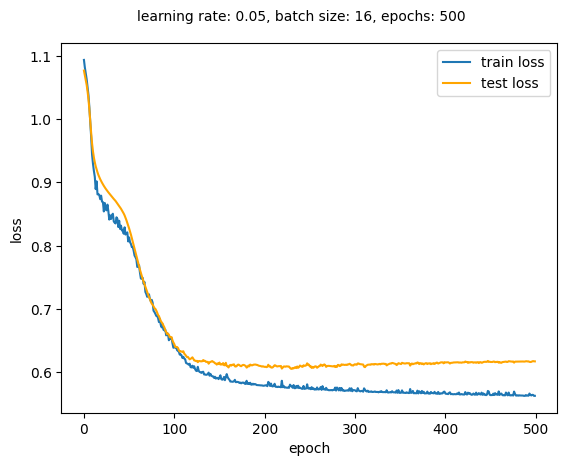

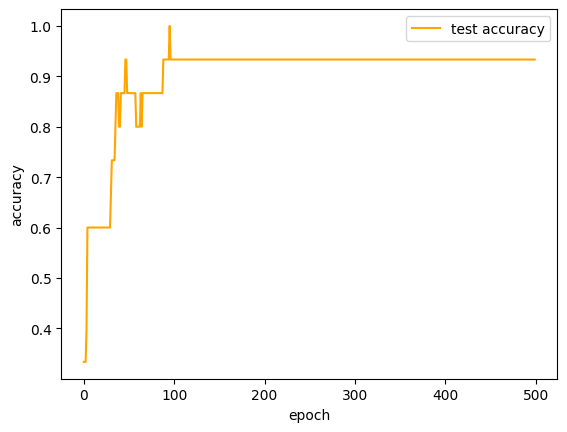

In [15]:
# ----------------------------------------------------------------------------------------------------------------
#    initera modell, loss_function, optimizer & dataloader


model = NeuralNetwork(input_size, output_size)
model = model.to(device)                                  # förbered modellen för GPU (om tillgänglig)


optimizer = SGD(model.parameters(), lr = learning_rate)
loss_function = torch.nn.CrossEntropyLoss()               # OBS, CrossEntropyLoss!

train_dataloader = DataLoader(training_set,                 
                              batch_size = batch_size,       
                              shuffle=True)


# ----------------------------------------------------------------------------------------------------------------
#    träna



batch_train_losses = []

epoch_train_losses = []
epoch_evaluation_losses = []
epoch_evaluation_accuracies = []

for epoch in range(epochs):
    
    model.train()

    running_loss = 0
    
    for batch in train_dataloader:
        
        y_true = batch[1]
        input_features = batch[0]
        
        y_pred=model(input_features)
        loss=loss_function(y_pred, y_true)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        batch_loss = loss.item()
        batch_train_losses.append(batch_loss)
    
    epoch_average_loss = np.average(batch_train_losses[-len(train_dataloader):])
    epoch_train_losses.append(epoch_average_loss)

# ----------------------------------------------------------------------------------------------------------------
#   evalueringssektion 

    #model.eval()
    
    y_true = y_test
    input_features = x_test
    
    y_pred = model(input_features)
    loss = loss_function(y_pred, y_true)
    
    evaluation_loss = loss.item()
    epoch_evaluation_losses.append(evaluation_loss)

# ----------------------------------------------------------------------------------------------------------------
#   evalueringssektion del 2 - samla in accuracy på test set


    _, predicted_class = torch.max(y_pred, dim=1)
    accuracy = (predicted_class == y_true).float().mean().item()
    epoch_evaluation_accuracies.append(accuracy)

# ----------------------------------------------------------------------------------------------------------------
#   plotta resultat 

# printa också
print(accuracy)

plt.plot(epoch_train_losses, label = 'train loss')
plt.plot(epoch_evaluation_losses, label = 'test loss', color='orange')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.suptitle(f'learning rate: {learning_rate}, '
            f'batch size: {batch_size}, '
            f'epochs: {epochs}', fontsize=10, y=0.95)

plt.show()

plt.plot(epoch_evaluation_accuracies, label = 'test accuracy', color='orange')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [21]:
import torch.nn.functional as F
from torch.optim import SGD, Adam, Adadelta
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import warnings
from torch.optim.lr_scheduler import StepLR
import seaborn as sns
warnings.filterwarnings('ignore')

class ModelTrainer:
    def __init__(self, input_size, output_size, device, batch_size=16, learning_rate=0.001, verbose=True, l2_lambda=0.0):
        self.input_size = input_size
        self.output_size = output_size
        self.device = device
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.verbose = verbose  # control print statements
        
        # initialize model
        self.model = NeuralNetwork(input_size, output_size).to(device)

        # loss function based on output size
        if output_size == 1:
            self.loss_function = torch.nn.BCELoss()
        else:
            self.loss_function = torch.nn.CrossEntropyLoss()


        self.optimizer = SGD(self.model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
        # self.optimizer = Adadelta(self.model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
        
        # initialize storage for epoch averages of losses
        self.train_losses = []
        self.test_losses = []
        self.current_epoch = 0

        # initialize scheduler as None
        self.scheduler = None

    def set_learning_rate(self, new_lr):
        """Update learning rate of the optimizer"""
        self.learning_rate = new_lr
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr
        
    def setup_data_loaders(self, training_set, test_set):
        self.train_dataloader = DataLoader(training_set,
                                         batch_size=self.batch_size,
                                         shuffle=True)
        self.test_dataloader = DataLoader(test_set,
                                        batch_size=len(test_set),
                                        shuffle=False)
    
    def train_epoch(self, epoch):
        self.model.train()
        batch_losses = []
        
        # verbose print formatting: calculate field widths based on total values
        total_samples = len(self.train_dataloader.dataset)
        epoch_width = len(str(self.current_epoch + 1))
        sample_width = len(str(total_samples))
        
        for batch_idx, (data, target) in enumerate(self.train_dataloader):
            data, target = data.to(self.device), target.to(self.device)
            
            if self.output_size == 1:
                target = target.float()  # ensure target is float for BCEWithLogitsLoss
            
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = self.loss_function(output, target)
            loss.backward()
            self.optimizer.step()
            
            batch_losses.append(loss.item())
            if self.verbose and batch_idx % 10 == 0:
                samples_processed = batch_idx * len(data)
                percentage = 100. * batch_idx / len(self.train_dataloader)
                print(f'train epoch: {epoch:{epoch_width}} '
                    f'[{samples_processed:>{sample_width}}/{total_samples} ({percentage:.0f}%)]\t'
                    f'loss: {loss.item():.6f}')
        
        epoch_average_loss = np.average(batch_losses)
        self.train_losses.append(epoch_average_loss)
        return epoch_average_loss
    
    def test(self, epoch):
        self.model.eval()
        with torch.no_grad():
            data, target = next(iter(self.test_dataloader))
            data, target = data.to(self.device), target.to(self.device)

            if self.output_size == 1:
                target = target.float()

            output = self.model(data)
            loss = self.loss_function(output, target)
            test_loss = loss.item()

            # calculate accuracy
            
            if self.output_size == 1:
                predicted = (output > 0.5).float()  # threshold at 0.5 for binary classification
            else:
                _, predicted = torch.max(output, dim=1)  # get predicted class indices for multi-class
            
            correct = (predicted == target).sum().item()
            total = target.size(0)
            
            self.test_losses.append(test_loss)  # save loss for this epoch

            train_loss = self.train_losses[-1]  # get latest epoch average training loss

            if self.verbose:
                print(f'\nEpoch {epoch}:')
                print(f'Training loss: {train_loss:.4f}')
                print(f'Test loss: {test_loss:.4f}')
                print(f'Accuracy: {correct}/{total} ({100. * correct / total:.0f}%)\n')
            else:
                print(f'[epoch {epoch}] train loss: {train_loss:.4f}, test loss: {test_loss:.4f}, '
                    f'accuracy: {correct}/{total} ({100. * correct / total:.0f}%)')
            return test_loss
    
    def train(self, training_set, test_set, num_epochs=5, gamma=None):
        # setup data loaders
        self.setup_data_loaders(training_set, test_set)

        # initialize scheduler if gamma is provided
        if gamma is not None:
            self.scheduler = StepLR(self.optimizer, step_size=1, gamma=gamma)

        start_epoch = self.current_epoch + 1
        end_epoch = start_epoch + num_epochs
        
        # training loop
        for epoch in range(start_epoch, end_epoch):
            train_loss = self.train_epoch(epoch)
            test_loss = self.test(epoch)
            self.current_epoch = epoch

            # step the scheduler if it's initialized
            if self.scheduler is not None:
                self.scheduler.step()
        
        # plot results
        self.plot_losses()
        
        return self.model
    
    def plot_losses(self, start_epoch=None, end_epoch=None):
        plt.figure(figsize=(10, 6))
        
        # handle negative start_epoch (counting from end)
        if start_epoch and start_epoch < 0:
            start_epoch = self.current_epoch + start_epoch + 1
        
        # default to all epochs if no range specified
        if start_epoch is None:
            start_epoch = 1
        if end_epoch is None:
            end_epoch = self.current_epoch

        # adjust for zero-based index
        start_index = start_epoch - 1
        end_index = end_epoch

        epochs = range(start_epoch, end_epoch + 1)
        train_losses = self.train_losses[start_index:end_index]
        test_losses = self.test_losses[start_index:end_index]

        plt.plot(epochs, train_losses, label='train loss')
        plt.plot(epochs, test_losses, label='test loss')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.title('training and test losses')

        plt.suptitle(f'learning rate: {self.learning_rate}, '
                    f'batch size: {self.batch_size}, '
                    f'epochs: {end_epoch - start_epoch + 1}', fontsize=10, y=0.95)

        plt.legend()

        # set y-axis to standard decimal notation
        plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.4f}'))
        
        # show at most 20 ticks on x-axis
        max_ticks = 20
        step = max(len(epochs) // max_ticks, 1)
        plt.xticks(list(epochs)[::step])
        
        plt.grid(False)
        sns.despine()
        plt.show()

[epoch 1] train loss: 1.1019, test loss: 1.0921, accuracy: 6/15 (40%)
[epoch 2] train loss: 1.0966, test loss: 1.0918, accuracy: 6/15 (40%)
[epoch 3] train loss: 1.0998, test loss: 1.0917, accuracy: 6/15 (40%)
[epoch 4] train loss: 1.0973, test loss: 1.0913, accuracy: 6/15 (40%)
[epoch 5] train loss: 1.0982, test loss: 1.0909, accuracy: 6/15 (40%)
[epoch 6] train loss: 1.0970, test loss: 1.0905, accuracy: 6/15 (40%)
[epoch 7] train loss: 1.0947, test loss: 1.0901, accuracy: 6/15 (40%)
[epoch 8] train loss: 1.0945, test loss: 1.0896, accuracy: 6/15 (40%)
[epoch 9] train loss: 1.0955, test loss: 1.0891, accuracy: 6/15 (40%)
[epoch 10] train loss: 1.0922, test loss: 1.0886, accuracy: 6/15 (40%)
[epoch 11] train loss: 1.0941, test loss: 1.0879, accuracy: 6/15 (40%)
[epoch 12] train loss: 1.0909, test loss: 1.0873, accuracy: 6/15 (40%)
[epoch 13] train loss: 1.0936, test loss: 1.0866, accuracy: 6/15 (40%)
[epoch 14] train loss: 1.0898, test loss: 1.0859, accuracy: 6/15 (40%)
[epoch 15] trai

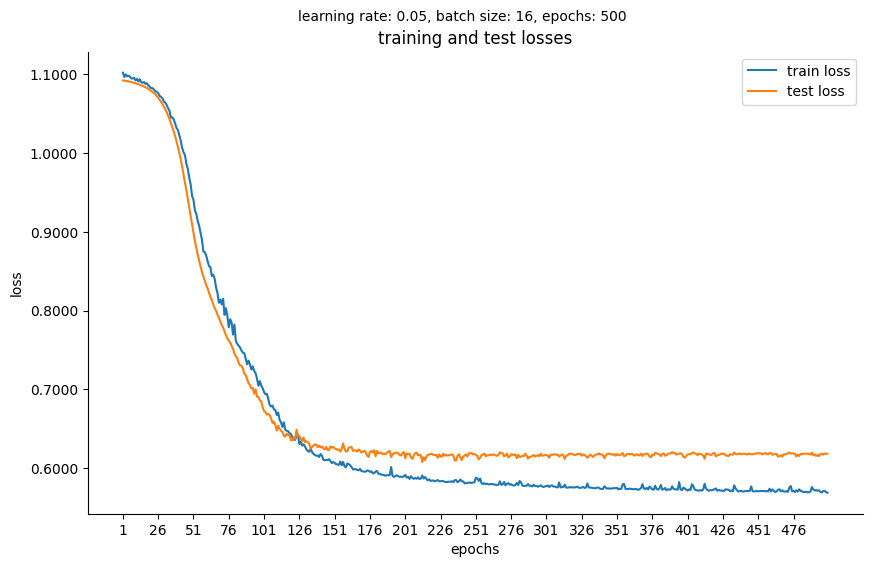

In [23]:
# initialize trainer
trainer = ModelTrainer(
    input_size=input_size,
    output_size=output_size,
    device=device,
    batch_size=batch_size,
    learning_rate=learning_rate,
    verbose=False
)

# train model
trained_model = trainer.train(
    training_set=training_set,
    test_set=test_set,
    num_epochs=epochs
) 

**Uppgift 5)**

Försök få så bra prestanda som möjligt genom att ändra nätverkets kapacitet. Börja med att justera antal lager och antal neuroner i varje lager.

**Uppgift 6)**

Om du anser det nödvändigt, lägg även till Dropout